## **Proyecto Final - Enfermedad Hepática (ILPD)**

- Made by: John Fredy Beltran Cuellar y Santiago Trejo
- Date: 11/04/2025
- Goal: Desarrollar y evaluar un modelo de clasificación basado en técnicas de Machine Learning para predecir la presencia de enfermedad hepática en pacientes, utilizando el dataset ILPD, con el fin de apoyar el proceso de diagnóstico clínico y contribuir a la toma de decisiones en el ámbito de la salud.


In [30]:
#step 0. load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import (train_test_split,
                                     StratifiedGroupKFold,
                                     RandomizedSearchCV,
                                     GridSearchCV)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, roc_auc_score,
                             ConfusionMatrixDisplay, accuracy_score,
                             precision_score, recall_score,f1_score,
                             RocCurveDisplay)
from collections import Counter
#Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
#Manejo de alertas
import warnings

In [31]:
# step 1. load data
# Carga y rename
url="/workspaces/projecto_final_clasificacion_ILPD/Indian Liver Patient Dataset (ILPD).csv"
df_raw = pd.read_csv(url)
df_raw.columns = ["Age","Gender","TB","DB","Alkphos","Sgpt","Sgot","TP","ALB","A/G Ratio","Target"]
warnings.filterwarnings('ignore')



Tabla 1. Diccionario de Variables del Dataset ILPD
| Nombre del Campo | Nombre Completo | Descripción | Unidades / Valores |
|---|---|---|---|
| **Age** | Edad del Paciente | Edad del paciente en años | Años |
| **Gender** | Género | Sexo biológico del paciente | Male / Female |
| **TB** | Total Bilirubin | Nivel total de bilirrubina en sangre | mg/dL |
| **DB** | Direct Bilirubin | Bilirrubina conjugada; elevada indica daño hepático | mg/dL |
| **Alkphos** | Alkaline Phosphatase | Enzima asociada a obstrucción biliar o daño hepático | IU/L |
| **Sgpt** | ALT — Alanine Aminotransferase | Enzima hepática, elevada en daño hepático | IU/L |
| **Sgot** | AST — Aspartate Aminotransferase | Enzima hepática, elevada en inflamación hepática o daño muscular | IU/L |
| **TP** | Total Proteins | Cantidad total de proteínas en sangre | g/dL |
| **ALB** | Albumin | Proteína producida por el hígado; baja indica fallo hepático | g/dL |
| **A/G Ratio** | Albumin/Globulin Ratio | Relación albúmina–globulina; baja en enfermedad hepática | Razón |
| **Liver Disease** | Indicador de Enfermedad Hepática | Indica si el paciente tiene enfermedad hepática | 1 = Enfermo / 2 = Sano |

In [32]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582 entries, 0 to 581
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        582 non-null    int64  
 1   Gender     582 non-null    object 
 2   TB         582 non-null    float64
 3   DB         582 non-null    float64
 4   Alkphos    582 non-null    int64  
 5   Sgpt       582 non-null    int64  
 6   Sgot       582 non-null    int64  
 7   TP         582 non-null    float64
 8   ALB        582 non-null    float64
 9   A/G Ratio  578 non-null    float64
 10  Target     582 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.1+ KB


In [33]:
df_raw.sample(20)

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Target
222,50,Male,1.1,0.3,175,20,19,7.1,4.5,1.70,2
77,70,Male,1.4,0.6,146,12,24,6.2,3.8,1.58,2
63,57,Male,1.3,0.4,259,40,86,6.5,2.5,0.60,1
298,24,Female,0.9,0.2,195,40,35,7.4,4.1,1.20,2
348,49,Female,0.8,0.2,158,19,15,6.6,3.6,1.20,2
498,55,Male,3.6,1.6,349,40,70,7.2,2.9,0.60,1
451,58,Male,0.9,0.2,1100,25,36,7.1,3.5,0.90,1
555,51,Male,0.7,0.1,180,25,27,6.1,3.1,1.00,1
331,26,Male,7.1,3.3,258,80,113,6.2,2.9,0.80,1
285,34,Female,0.8,0.2,192,15,12,8.6,4.7,1.20,1


In [34]:
# step 2. preprecessing
df_baking = df_raw.copy()
df_baking.columns = df_baking.columns.str.lower().str.replace(" ", "_").str.replace("/", "_")
df_baking['gender'] = df_baking['gender'].astype('category')
df_baking['a_g_ratio'].fillna(df_baking['a_g_ratio'].median(), inplace=True)
df_baking.isna().sum()
df_baking['target'] = df_baking['target'].map({1: 'yes', 2: 'no'})
df_baking['target'] = df_baking['target'].astype('category')

df = df_baking.copy()

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582 entries, 0 to 581
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        582 non-null    int64   
 1   gender     582 non-null    category
 2   tb         582 non-null    float64 
 3   db         582 non-null    float64 
 4   alkphos    582 non-null    int64   
 5   sgpt       582 non-null    int64   
 6   sgot       582 non-null    int64   
 7   tp         582 non-null    float64 
 8   alb        582 non-null    float64 
 9   a_g_ratio  582 non-null    float64 
 10  target     582 non-null    category
dtypes: category(2), float64(5), int64(4)
memory usage: 42.4 KB


In [36]:
# step 3. EDA
# Dividimos en train/test
df_train, df_test = train_test_split(df, test_size=0.33,stratify=df['target'], random_state=2024)

# Resetear índices
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_train.shape, df_test.shape

((389, 11), (193, 11))

In [37]:
display(df_train.describe(include='number').T.assign(range=lambda x: x['max']-x['min'], cv=lambda x: x['std']/x['mean']))
display(df_train.describe(include='category').T)


,count,mean,std,min,25%,50%,75%,max,range,cv
age,389.0,46.272494,16.201622,4.0,34.0,47.0,60.0,90.0,86.0,0.350135
tb,389.0,3.272237,6.355357,0.4,0.8,1.0,2.7,75.0,74.6,1.942206
db,389.0,1.447558,2.730739,0.1,0.2,0.3,1.3,18.3,18.2,1.886445
alkphos,389.0,304.082262,268.625344,63.0,176.0,214.0,302.0,2110.0,2047.0,0.883397
sgpt,389.0,77.784062,173.500393,10.0,23.0,35.0,60.0,2000.0,1990.0,2.230539
sgot,389.0,113.203085,323.282396,11.0,26.0,43.0,88.0,4929.0,4918.0,2.855774
tp,389.0,6.464267,1.079415,2.8,5.8,6.5,7.1,9.5,6.7,0.166982
alb,389.0,3.099486,0.765661,1.0,2.5,3.1,3.7,4.9,3.9,0.247028
a_g_ratio,389.0,0.922262,0.294376,0.3,0.7,0.9,1.1,2.5,2.2,0.319189


,count,unique,top,freq
gender,389,2,Male,291
target,389,2,yes,277


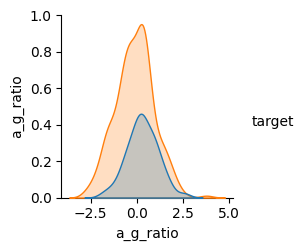

In [38]:
from sklearn.preprocessing import PowerTransformer
p_trans = PowerTransformer().set_output(transform='pandas')
my_var = df_train[['a_g_ratio']]
my_var_trans = p_trans.fit_transform(my_var)
my_var_trans['target'] = df_train['target']
sns.pairplot(my_var_trans, hue='target')
plt.show()

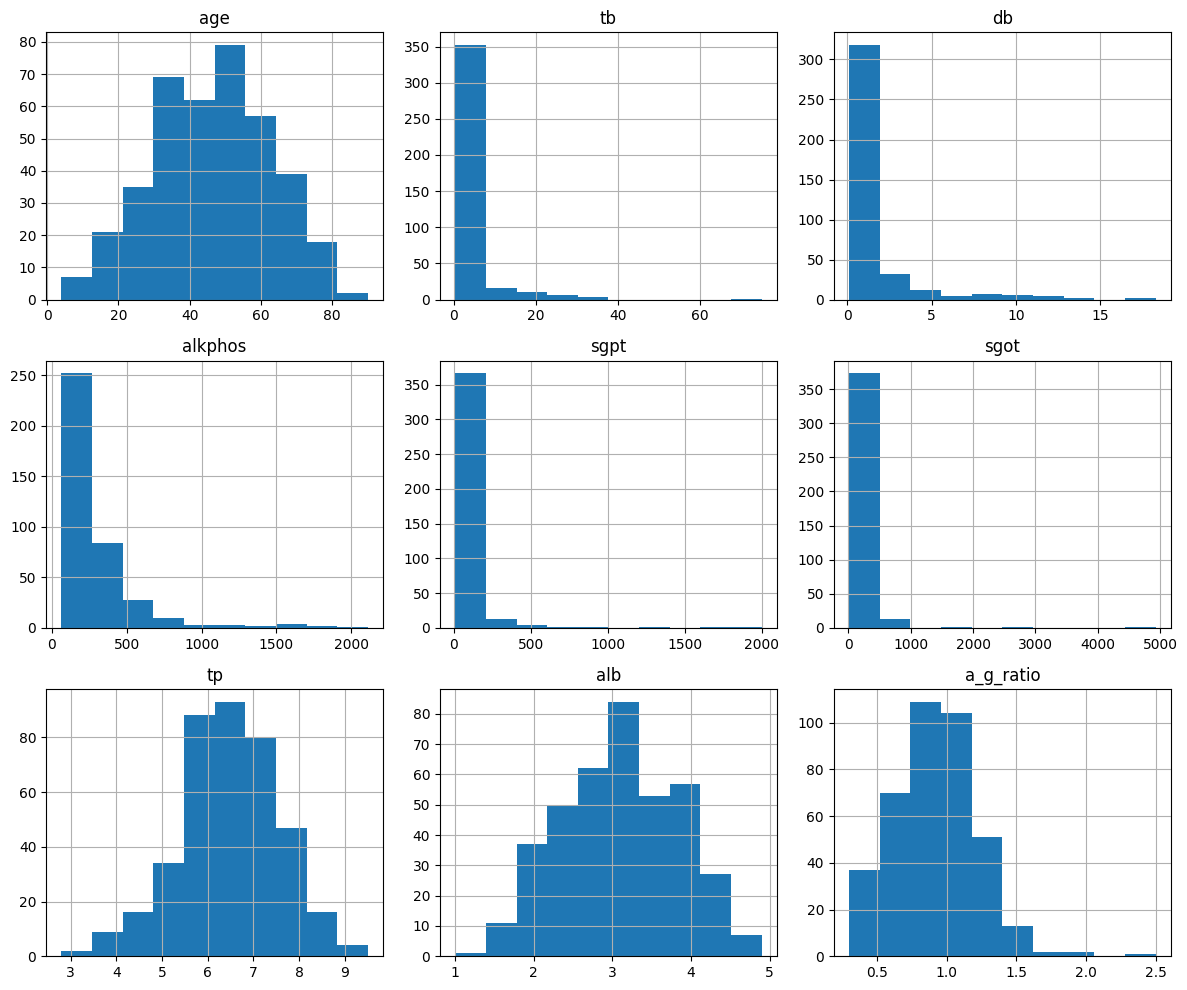

In [39]:
df_train.hist(figsize=(12,10))
plt.tight_layout()
plt.show()

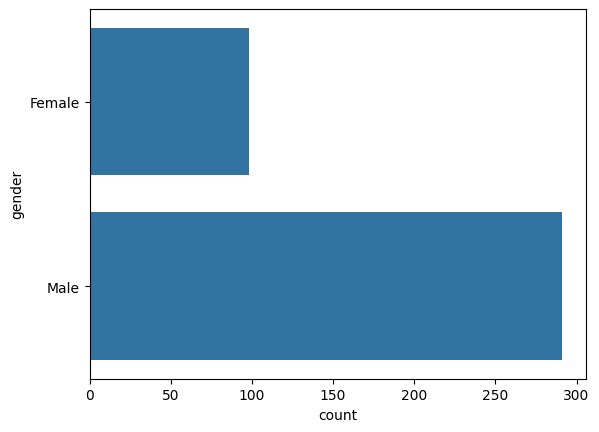

In [40]:
sns.countplot(df_train['gender'])
plt.savefig("gender_count.png")
plt.show()

In [41]:
positivos = df["target"].value_counts().loc["yes"]
negativos = df["target"].value_counts().loc["no"]
print("=== Conteo de casos positivos y negativos ===\n")
print(f"Casos positivos: {positivos}")
print(f"Casos negativos: {negativos}")

=== Conteo de casos positivos y negativos ===

Casos positivos: 415
Casos negativos: 167


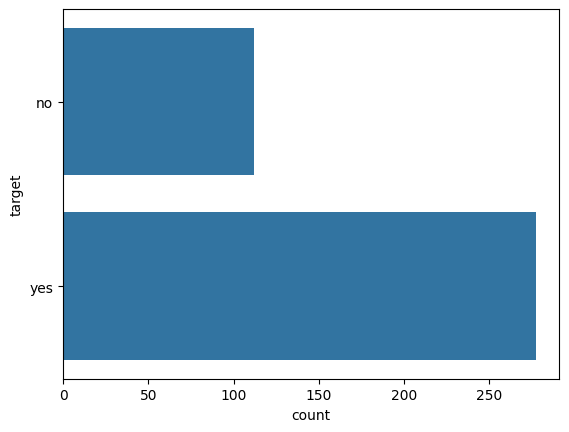

In [43]:
sns.countplot(df_train['target'])
plt.savefig("target_count.png")
plt.show()

In [44]:
df_train.head(2)

,age,gender,tb,db,alkphos,sgpt,sgot,tp,alb,a_g_ratio,target
0,66,Male,17.3,8.5,388,173,367,7.8,2.6,0.5,yes
1,51,Male,2.9,1.3,482,22,34,7.0,2.4,0.5,yes


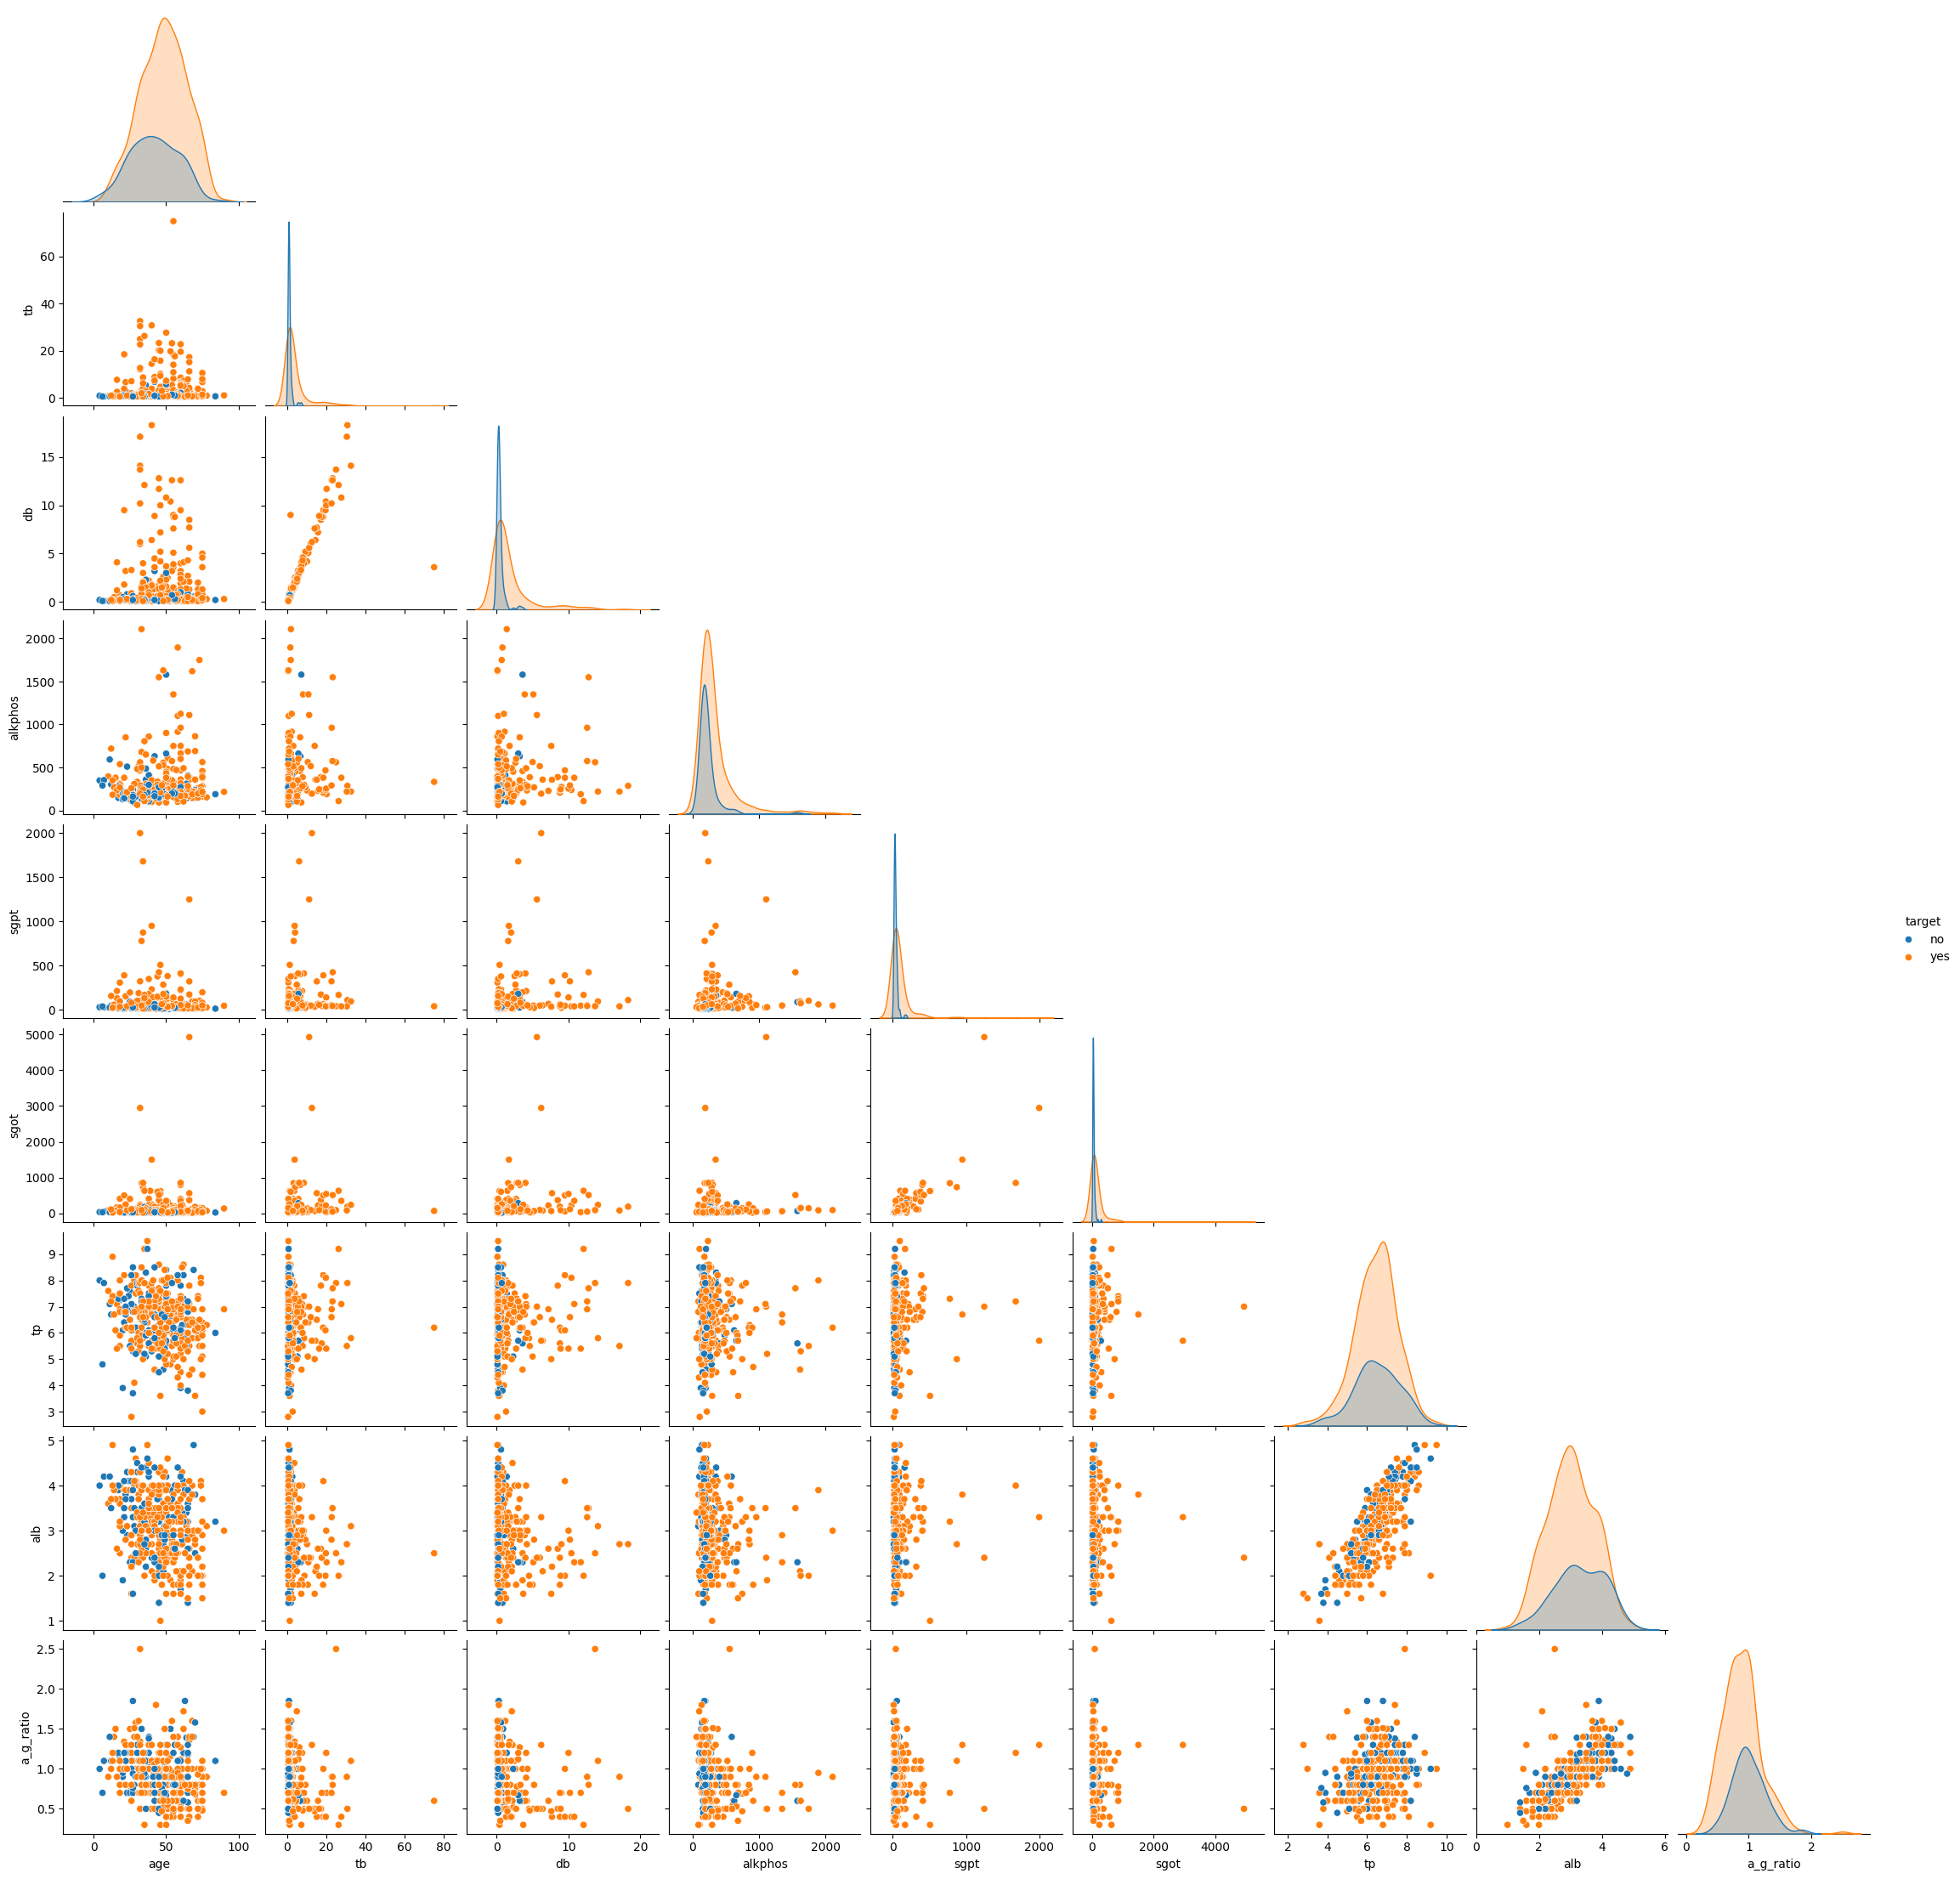

In [45]:
sns.pairplot(df_train, hue='target', corner=True)
plt.show()


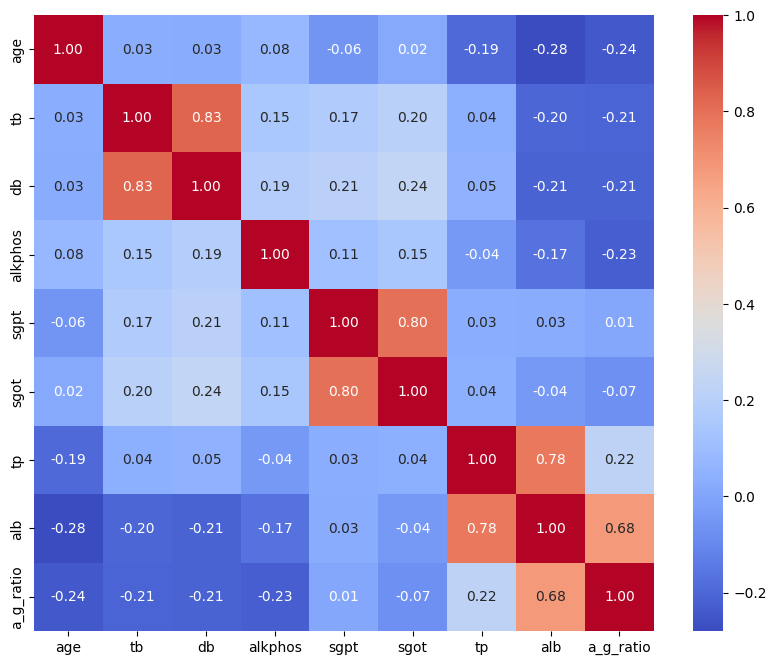

In [46]:
numeric_cols = df_train.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(10,8))
sns.heatmap(df_train[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.savefig("heatmap.png")
plt.show()

### ML y asignación de datos

In [47]:
# step 4. ML
# Separar X e y
X_train = df_train.drop('target', axis=1)
y_train = df_train['target']
X_test = df_test.drop('target', axis=1)
y_test = df_test['target']

In [48]:
# Codificar etiquetas a 0,1,...n
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [49]:
X_train.select_dtypes(include='number').columns.tolist()

['age', 'tb', 'db', 'alkphos', 'sgpt', 'sgot', 'tp', 'alb', 'a_g_ratio']

In [50]:
# Columnas numéricas y categóricas
numeric_features = ["age","tb","alkphos","sgpt","alb","a_g_ratio"]
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

proc_numeric = Pipeline([
    ('trans', PowerTransformer())
])
proc_categorical = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', proc_numeric, numeric_features),
        ('cat', proc_categorical, categorical_features)
    ]
)

In [51]:
#=====Modelos de clasificacion=====

# Logistic Regression model
clf_lr = Pipeline([
    ('processor', preprocessor),
    ('logreg', LogisticRegression(class_weight='balanced') )
])
# Random Forest model
clf_rf = Pipeline([
    ('processor', preprocessor),
    ('rf', RandomForestClassifier(class_weight='balanced'))
])
#SVC
clf_svc = Pipeline([
    ('processor', preprocessor),
    ('svc', SVC(random_state=2025, probability=True))
])
#Gaussian
clf_gaus = Pipeline([
    ('processor', preprocessor),
    ('gaus', GaussianNB())
])

### modelos

In [52]:
#Comparación de modelos sin hiperparámetro
models = [(clf_lr, "Logistic Regression", "logreg__"),
          (clf_rf, "Random Forest", "rf__"),
          (clf_svc, "SVC", "svc__"),
          (clf_gaus, "GaussianNB", "gaus__")
          ]

performance={}
reports = {}
for est,name, sname in models:
  est.fit(X_train, y_train_enc)
  y_hat = est.predict(X_train)

  #Guardamos un classification report para cada modelo
  report_text = classification_report(y_train_enc, y_hat, target_names=le.classes_)
  reports[name] = report_text

  #metricas de evaluacion
  accuracy = round(accuracy_score(y_train_enc, y_hat),2)
  f1 = round(f1_score(y_train_enc, y_hat),2)

  performance[name] = {
      "accuracy":accuracy,
      "F1 score":f1,
  }

  print(f"==== Classification Report for {name} ====")
  print(report_text)
  print("\n================================================")

==== Classification Report for Logistic Regression ====
              precision    recall  f1-score   support

          no       0.48      0.77      0.59       112
         yes       0.88      0.67      0.76       277

    accuracy                           0.70       389
   macro avg       0.68      0.72      0.68       389
weighted avg       0.76      0.70      0.71       389


==== Classification Report for Random Forest ====
              precision    recall  f1-score   support

          no       1.00      1.00      1.00       112
         yes       1.00      1.00      1.00       277

    accuracy                           1.00       389
   macro avg       1.00      1.00      1.00       389
weighted avg       1.00      1.00      1.00       389


==== Classification Report for SVC ====
              precision    recall  f1-score   support

          no       0.77      0.24      0.37       112
         yes       0.76      0.97      0.85       277

    accuracy                      

In [53]:
df_models = pd.DataFrame(performance)
df_models.T

,accuracy,F1 score
Logistic Regression,0.70,0.76
Random Forest,1.00,1.00
SVC,0.76,0.85
GaussianNB,0.71,0.79


A pesar de que el modelo RandomForest se adapta demasiado a los datos de entrenamiento, intentamos mejorarlo con hiperparámetros.

### modelos y comparación


In [54]:
#Comparación de modelos con hyperparámetro

param_grids = {
    'logreg__':{
      'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
      'logreg__penalty': ['l2'],
      'logreg__solver': ['liblinear', 'saga', 'lbfgs'],
      'logreg__class_weight': ['balanced']
    },
    'rf__':{
      'rf__max_depth': [1,2,3,4,5,6,7],
      'rf__min_samples_leaf': [2,4,6],
      'rf__n_estimators':[5,100]
},
    'svc__':{
      'svc__C': [0.1, 1, 10, 100],
      'svc__kernel': ['linear', 'rbf'],
      'svc__gamma': ['scale', 0.1, 1],
      'svc__class_weight': ['balanced']
    },
    'gaus__':{
      'gaus__var_smoothing': [1e-9]
    }
}


performance={}
reports = {}
for est,name, sname in models:
  est.fit(X_train, y_train_enc)
  estimator_cv = GridSearchCV(
      est,
      param_grid = param_grids[sname],
      cv = 5,
      scoring = 'recall'
  )
  estimator_cv.fit(X_train, y_train_enc)
  y_hat = estimator_cv.predict(X_train)

  #Guardamos un classification report para cada modelo
  report_text = classification_report(y_train_enc, y_hat, target_names=le.classes_)
  reports[name] = report_text

  #metricas de evaluacion
  accuracy = round(accuracy_score(y_train_enc, y_hat),2)
  f1 = round(f1_score(y_train_enc, y_hat),2)
  params = estimator_cv.best_params_

  performance[name] = {
      "accuracy":accuracy,
      "F1 score":f1,
      "Best Params":params,
  }

  print(f"==== Classification Report for {name} ====")
  print(report_text)
  print("\n================================================")

==== Classification Report for Logistic Regression ====
              precision    recall  f1-score   support

          no       0.48      0.77      0.59       112
         yes       0.88      0.66      0.76       277

    accuracy                           0.69       389
   macro avg       0.68      0.72      0.67       389
weighted avg       0.76      0.69      0.71       389


==== Classification Report for Random Forest ====
              precision    recall  f1-score   support

          no       0.69      0.88      0.77       112
         yes       0.94      0.84      0.89       277

    accuracy                           0.85       389
   macro avg       0.81      0.86      0.83       389
weighted avg       0.87      0.85      0.85       389


==== Classification Report for SVC ====
              precision    recall  f1-score   support

          no       0.98      1.00      0.99       112
         yes       1.00      0.99      1.00       277

    accuracy                      

In [55]:
df_models_optimizated = pd.DataFrame(performance)
df_models_optimizated.T

,accuracy,F1 score,Best Params
Logistic Regression,0.69,0.76,"{'logreg__C': 1, 'logreg__class_weight': 'bala..."
Random Forest,0.85,0.89,"{'rf__max_depth': 7, 'rf__min_samples_leaf': 2..."
SVC,0.99,1.0,"{'svc__C': 10, 'svc__class_weight': 'balanced'..."
GaussianNB,0.71,0.79,{'gaus__var_smoothing': 1e-09}


# Parte de evaluación

              precision    recall  f1-score   support

          no       0.45      0.71      0.55        55
         yes       0.85      0.66      0.74       138

    accuracy                           0.67       193
   macro avg       0.65      0.68      0.65       193
weighted avg       0.74      0.67      0.69       193



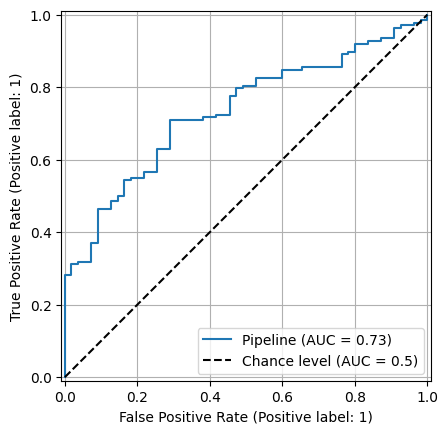

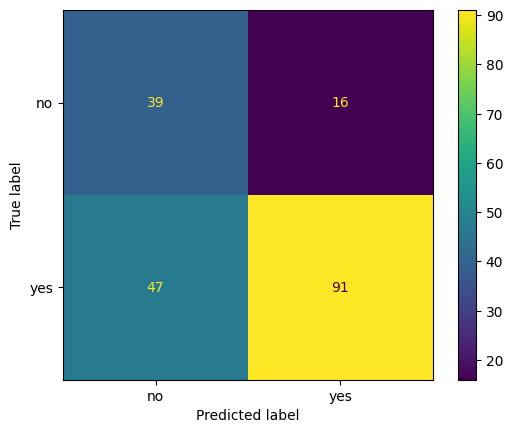

In [56]:
clf_rf_est = Pipeline([
    ('processor', preprocessor),
    ('rf', RandomForestClassifier(class_weight='balanced',
                                  max_depth=7,
                                  min_samples_leaf=2,
                                  n_estimators=100
                                  ))

])
clf_rf_est.fit(X_train, y_train_enc)
y_hat_rf = clf_rf_est.predict(X_test)
#guardado de modelo
joblib.dump(clf_rf_est, "modelo_rf.pkl")

print(classification_report(y_test_enc, y_hat_rf, target_names=le.classes_))
print("===============================================================================")

#Curva ROC
RocCurveDisplay.from_estimator(
    clf_rf_est, X_test, y_test_enc, plot_chance_level=True
)
plt.grid(True)
plt.savefig('curvaROC.png')
plt.show()

print("===============================================================================")
#Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test_enc, y_hat_rf, display_labels=le.classes_)
plt.savefig('confusion_matrix.png')
plt.show()

Gráfico de importancia de variables guardado como 'feature_importance_plot.png'

## Importancia de Características (Top 5)
| Característica   |   Importancia |
|:-----------------|--------------:|
| tb               |      0.21672  |
| alkphos          |      0.21181  |
| sgpt             |      0.188394 |
| age              |      0.142831 |
| a_g_ratio        |      0.106603 |


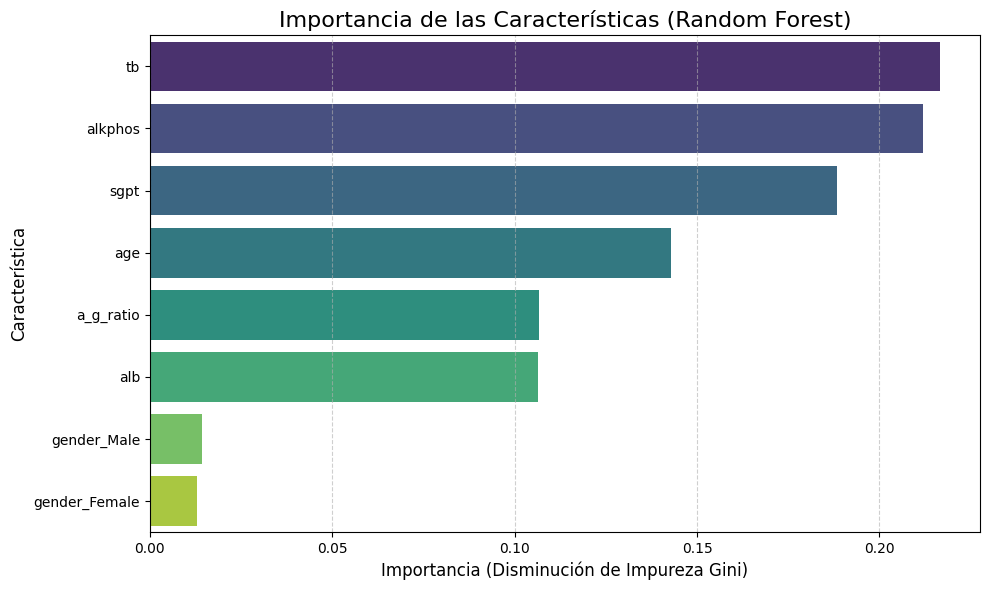

In [59]:
# 1. Obtener el modelo RF entrenado desde el pipeline
rf_model = clf_rf_est.named_steps['rf']

# 2. Obtener los nombres de las características finales después del preprocessor
# Intentar obtener los nombres usando el método out del preprocessor
try:
    feature_names = list(clf_rf_est.named_steps['processor'].get_feature_names_out(input_features=X_train.columns))
    # Limpiar los prefijos si existen
    feature_names = [name.split('__')[1] if '__' in name else name for name in feature_names]
except AttributeError:
    # Si falla, usar los nombres originales
    feature_names = X_train.columns.tolist()

# 3. Obtener las importancias
importances = rf_model.feature_importances_

# 4. Crear DataFrame para la visualización
feature_importance_df = pd.DataFrame({
    'Característica': feature_names,
    'Importancia': importances
})

# 5. Ordenar por importancia descendente
feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False)

# 6. Generar la gráfica
plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Característica', data=feature_importance_df, palette='viridis')
plt.title('Importancia de las Características (Random Forest)', fontsize=16)
plt.xlabel('Importancia (Disminución de Impureza Gini)', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('feature_importance_plot.png')
print("Gráfico de importancia de variables guardado como 'feature_importance_plot.png'")

# 7. Imprimir la tabla de resultados (Top 5)
print("\n## Importancia de Características (Top 5)")
print(feature_importance_df.head().to_markdown(index=False))